In [1]:
import pandas as pd 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import tensorflow as tf 

from tensorflow.keras.models import Model 
import numpy as np 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler 

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False 

In [2]:
!wget http://www.timeseriesclassification.com/Downloads/ECG5000.zip 

--2020-11-26 19:02:11--  http://www.timeseriesclassification.com/Downloads/ECG5000.zip
Resolving www.timeseriesclassification.com (www.timeseriesclassification.com)... 109.123.71.232
Connecting to www.timeseriesclassification.com (www.timeseriesclassification.com)|109.123.71.232|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10614407 (10M) [application/zip]
Saving to: ‘ECG5000.zip’

ECG5000.zip         100%[===================>]  10.12M  12.6MB/s    in 0.8s    

2020-11-26 19:02:12 (12.6 MB/s) - ‘ECG5000.zip’ saved [10614407/10614407]



In [3]:
!unzip ECG5000.zip

Archive:  ECG5000.zip
  inflating: ECG5000.txt             
  inflating: ECG5000_TEST.arff       
  inflating: ECG5000_TEST.txt        
  inflating: ECG5000_TRAIN.arff      
  inflating: ECG5000_TRAIN.txt       
  inflating: ECG5000_TEST.ts         
  inflating: ECG5000_TRAIN.ts        


In [4]:
!cat ECG5000_TRAIN.txt ECG5000_TEST.txt > ecg_final.txt

In [5]:
df = pd.read_csv('ecg_final.txt',sep='  ', header=None)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [6]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,1.0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,...,1.173345,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137
1,1.0,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,...,1.557410,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250
2,1.0,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,...,1.640105,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797
3,1.0,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,...,1.553079,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.406388,-0.327528,-0.460868,-0.402536,-0.345752,-0.354206,-0.439959,-0.425326,-0.439789,-0.451835,-0.395926,-0.448762,-0.391789,-0.376307,-0.461069,-0.253524,0.213006,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564
4,1.0,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,-0.298107,-0.428928,-0.491351,-0.361304,-0.339296,-0.324952,-0.290113,-0.363051,-0.525684,-0.597423,-0.575523,-0.567503,-0.504555,-0.618406,-0.682814,-0.743849,-0.815588,-0.826902,-0.782374,-0.929462,-0.999672,-1.060969,-1.007877,-1.028735,-1.122629,-1.028650,-1.046515,-1.063372,-1.122423,...,0.982230,1.155363,1.336254,1.627534,1.717594,1.696487,1.741686,1.674078,1.546928,1.331738,1.110168,0.922210,0.521777,0.154852,-0.123861,-0.202998,-0.247956,-0.219122,-0.214695,-0.319215,-0.198597,-0.151618,-0.129593,-0.074939,-0.1

### class 1.0 is the normal activity of the heart and rest of the classes indicate the irregular activity of the heart 


In [7]:
df = df.add_prefix('c')

In [8]:
df['c0'].value_counts()

1.0    2919
2.0    1767
4.0     194
3.0      96
5.0      24
Name: c0, dtype: int64

In [9]:
df.describe()

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19,c20,c21,c22,c23,c24,c25,c26,c27,c28,c29,c30,c31,c32,c33,c34,c35,c36,c37,c38,c39,...,c101,c102,c103,c104,c105,c106,c107,c108,c109,c110,c111,c112,c113,c114,c115,c116,c117,c118,c119,c120,c121,c122,c123,c124,c125,c126,c127,c128,c129,c130,c131,c132,c133,c134,c135,c136,c137,c138,c139,c140
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.527400,-0.262476,-1.649511,-2.492211,-3.119443,-3.167438,-2.866308,-2.273126,-1.798127,-1.410124,-0.936082,-0.586326,-0.434430,-0.337621,-0.258235,-0.184443,-0.120015,-0.070396,-0.041849,-0.037049,-0.041243,-0.048908,-0.060176,-0.070725,-0.085491,-0.101144,-0.116070,-0.134461,-0.155811,-0.177542,-0.200685,-0.224244,-0.246686,-0.271476,-0.290321,-0.304461,-0.315111,-0.316851,-0.313070,-0.303238,...,0.946527,1.051337,1.138071,1.187551,1.201909,1.190866,1.154605,1.086347,0.986863,0.864419,0.720300,0.570000,0.428955,0.319734,0.242586,0.181059,0.134708,0.109781,0.093630,0.081028,0.065780,0.047326,0.025409,0.004531,-0.009790,-0.019087,-0.026208,-0.029561,0.000637,0.086588,0.146319,0.070973,-0.062914,-0.276206,-0.507667,-0.761043,-0.834741,-0.642263,-0.487242,-0.706008
std,0.760372,1.152369,1.445493,1.386409,1.302802,1.104382,0.906133,0.731627,0.623100,0.637149,0.657945,0.592049,0.493606,0.426206,0.393553,0.382488,0.386315,0.400830,0.415267,0.423797,0.429734,0.434976,0.441768,0.447727,0.454600,0.461603,0.472726,0.483574,0.492048,0.503468,0.516169,0.530030,0.543061,0.552285,0.560649,0.564906,0.566459,0.560789,0.548964,0.536229,...,0.520027,0.574633,0.614855,0.623050,0.608319,0.582721,0.553923,0.531272,0.507226,0.485600,0.483479,0.511334,0.546391,0.565580,0.571998,0.573798,0.584480,0.589680,0.591613,0.597117,0.603953,0.610288,0.619812,0.633101,0.649239,0.667657,0.680713,0.693871,0.751844,0.920052,1.171299,1.404842,1.646585,1.895134,2.059758,2.086218,2.056220,1.859296,1.830987,1.414465
min,1.000000,-6.729499,-7.090374,-5.132459,-5.363241,-5.375715,-5.330194,-4.782240,-4.311288,-4.071361,-4.142476,-4.040526,-3.724538,-3.264576,-3.222345,-3.263484,-3.219212,-3.202187,-3.147504,-3.459917,-4.102102,-4.311241,-4.099888,-3.614973,-3.822298,-3.795567,-3.690817,-3.542485,-3.631665,-3.587112,-3.452215,-4.074752,-4.137454,-4.059662,-3.626646,-2.829471,-3.585866,-4.003401,-3.900724,-3.325329,...,-2.662170,-2.634950,-2.634768,-2.591663,-2.446476,-2.234175,-2.431403,-2.681604,-2.864706,-3.415656,-3.497624,-3.091282,-2.608510,-2.383204,-2.678883,-3.305661,-3.179590,-3.311559,-3.501555,-4.007212,-4.199563,-3.335678,-3.127603,-3.042532,-3.116177,-3.972320,-4.754057,-4.290016,-3.802469,-4.014642,-3.971715,-4.167040,-4.557576,-4.530488,-4.563270,-5.150100,-4.880460,-5.496107,-5.880890,-6.092227
25%,1.000000,-1.004511,-2.701576,-3.668096,-4.227247,-4.007470,-3.480479,-2.779941,-2.165851,-1.774124,-1.362068,-0.935730,-0.704797,-0.557938,-0.457267,-0.392099,-0.346567,-0.329879,-0.332123,-0.342879,-0.359587,-0.373523,-0.392615,-0.415157,-0.441247,-0.470702,-0.501586,-0.538227,-0.570103,-0.616792,-0.650610,-0.695386,-0.735151,-0.770997,-0.799982,-0.8121

##### Splitting the data into train test (75-25 split)

In [10]:
train_data, test_data, train_labels, test_labels = train_test_split(df.values, df.values[:,0:1], test_size=0.25, random_state=26)

Scaling the entire dataset on the train data alone

In [11]:
scaler = MinMaxScaler()
data_scaled = scaler.fit(train_data)

In [12]:
train_data_scaled = data_scaled.transform(train_data)

In [13]:
test_data_scaled = data_scaled.transform(test_data)

In [14]:
train_data_scaled

array([[0.25      , 0.62769167, 0.69756713, ..., 0.62888774, 0.65169114,
        0.68756909],
       [0.        , 0.66430573, 0.56301439, ..., 0.86658775, 0.73565367,
        0.43300442],
       [0.25      , 0.56978392, 0.58491893, ..., 0.38030581, 0.44481563,
        0.54160047],
       ...,
       [0.        , 0.52504769, 0.47743567, ..., 0.73189925, 0.71628258,
        0.57000088],
       [0.        , 0.55996138, 0.4998238 , ..., 0.68652189, 0.64722944,
        0.48053259],
       [0.75      , 0.53505002, 0.5205825 , ..., 0.31639317, 0.40549837,
        0.51147639]])

In [15]:
normal_train_data = pd.DataFrame(train_data_scaled).add_prefix('c').query('c0==0').values[:,1:]
anomaly_train_data = pd.DataFrame(train_data_scaled).add_prefix('c').query('c0 > 0').values[:,1:]

In [16]:
normal_test_data= pd.DataFrame(test_data_scaled).add_prefix('c').query('c0 == 0').values[:,1:]
anomaly_test_data = pd.DataFrame(test_data_scaled).add_prefix('c').query('c0 > 0').values[:,1:]

In [17]:
print(anomaly_train_data.shape)
print(anomaly_test_data.shape)
print(normal_train_data.shape)
print(normal_test_data.shape)

(1554, 140)
(527, 140)
(2196, 140)
(723, 140)


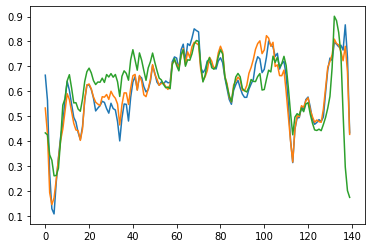

In [18]:
plt.plot(normal_train_data[0])
plt.plot(normal_train_data[1])
plt.plot(normal_train_data[2])

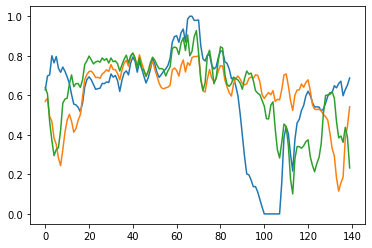

In [19]:
plt.plot(anomaly_train_data[0])
plt.plot(anomaly_train_data[1])
plt.plot(anomaly_train_data[2])

#Model 1 

In [20]:
class AutoEncoder(Model):
  def __init__(self,activation='relu'):
    super(AutoEncoder, self).__init__()
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Dense(64, activation=activation),
      tf.keras.layers.Dense(32, activation=activation),
      tf.keras.layers.Dense(16, activation=activation),
      tf.keras.layers.Dense(8, activation=activation)])
    
    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(16, activation=activation),
      tf.keras.layers.Dense(32, activation=activation),
      tf.keras.layers.Dense(64, activation=activation),
      tf.keras.layers.Dense(140, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [21]:
model= AutoEncoder()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')

model.compile(optimizer='adam', loss='mae')

In [22]:
history = model.fit(normal_train_data, normal_train_data, 
          epochs=50, 
          batch_size=128,
          validation_data=(train_data_scaled[:,1:], train_data_scaled[:,1:]),
          shuffle=True,
          callbacks=[early_stopping])

Epoch 1/50
18/18 [==============================] - 0s 12ms/step - loss: 0.1446 - val_loss: 0.1356
Epoch 2/50
18/18 [==============================] - 0s 5ms/step - loss: 0.1057 - val_loss: 0.0955
Epoch 3/50
18/18 [==============================] - 0s 5ms/step - loss: 0.0640 - val_loss: 0.0774
Epoch 4/50
18/18 [==============================] - 0s 5ms/step - loss: 0.0499 - val_loss: 0.0747
Epoch 5/50
18/18 [==============================] - 0s 5ms/step - loss: 0.0473 - val_loss: 0.0746
Epoch 6/50
18/18 [==============================] - 0s 4ms/step - loss: 0.0467 - val_loss: 0.0739
Epoch 7/50
18/18 [==============================] - 0s 5ms/step - loss: 0.0465 - val_loss: 0.0736
Epoch 8/50
18/18 [==============================] - 0s 4ms/step - loss: 0.0462 - val_loss: 0.0732
Epoch 9/50
18/18 [==============================] - 0s 4ms/step - loss: 0.0460 - val_loss: 0.0729
Epoch 10/50
18/18 [==============================] - 0s 5ms/step - loss: 0.0458 - val_loss: 0.0727
Epoch 11/50
18/18 

In [24]:
model.summary()

Model: "auto_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 8)                 11768     
_________________________________________________________________
sequential_1 (Sequential)    (None, 140)               11900     
Total params: 23,668
Trainable params: 23,668
Non-trainable params: 0
_________________________________________________________________


In [23]:
encoder_out = model.encoder(normal_test_data).numpy()
decoder_out = model.decoder(encoder_out).numpy()

In [ ]:
encoder_out.shape

(723, 8)

In [ ]:
decoder_out.shape

(723, 140)

<tf.Tensor: shape=(), dtype=float64, numpy=0.025575699446454454>

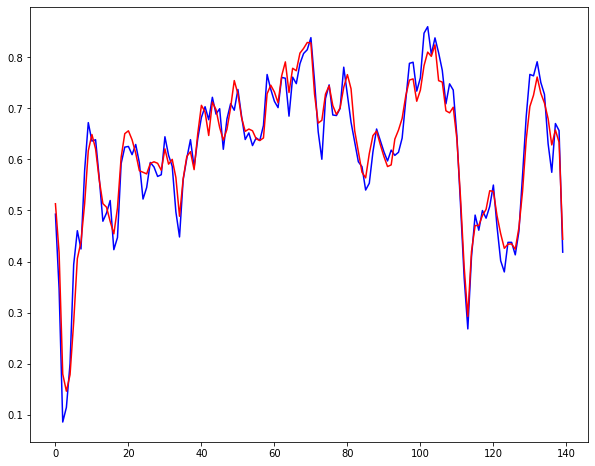

In [ ]:
plt.plot(normal_test_data[0],'b')
plt.plot(decoder_out[0],'r')
tf.keras.losses.mae(decoder_out[0], normal_test_data[0])

In [ ]:
encoder_out_a = model.encoder(anomaly_test_data).numpy()
decoder_out_a = model.decoder(encoder_out_a).numpy()

<tf.Tensor: shape=(), dtype=float64, numpy=0.12018276421531157>

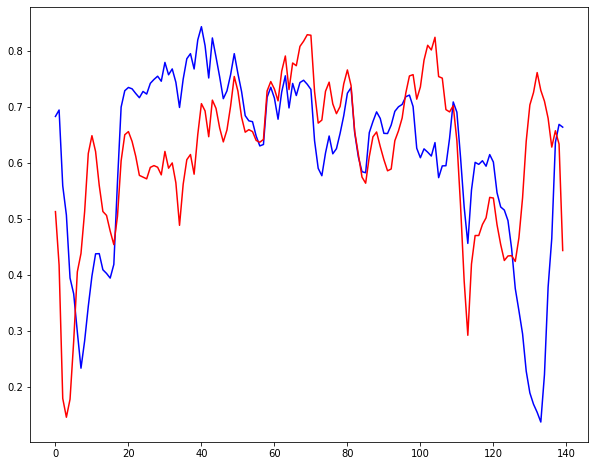

In [ ]:
plt.plot(anomaly_test_data[0],'b')
plt.plot(decoder_out[0],'r')
tf.keras.losses.mae(decoder_out[0], anomaly_test_data[0])

(array([10., 43., 69., 70., 70., 73., 54., 60., 42., 36., 42., 32., 26.,
        18., 14., 15., 11.,  8.,  7.,  3.,  5.,  6.,  2.,  0.,  1.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  2.,  0.,  1.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.01226982, 0.01499247, 0.01771512, 0.02043777, 0.02316042,
        0.02588307, 0.02860572, 0.03132837, 0.03405101, 0.03677366,
        0.03949631, 0.04221896, 0.04494161, 0.04766426, 0.05038691,
        0.05310956, 0.05583221, 0.05855486, 0.06127751, 0.06400016,
        0.06672281, 0.06944546, 0.07216811, 0.07489076, 0.07761341,
        0.08033606, 0.08305871, 0.08578136, 0.08850401, 0.09122666,
        0.09394931, 0.09667196, 0.09939461, 0.10211726, 0.10483991,
        0.10756255, 0.1102852 , 0.11300785, 0.1157305 , 0.11845315,
        0.1211758 , 0.12389845, 0.1266211 , 0.12934375, 0.1320664 ,
        0.13478905, 0.1375117 , 0.14023435, 0.142957  , 0.14567965,
        0.1484023 ]),
 <a list of 50

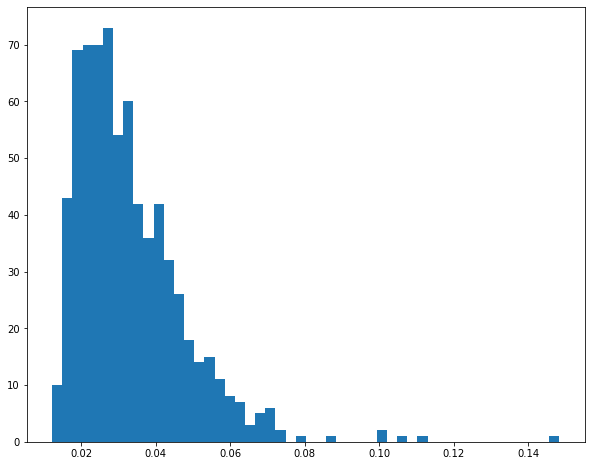

In [ ]:
reconstructions = model.predict(normal_test_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_test_data)

plt.hist(train_loss, bins=50)

In [ ]:
np.mean(train_loss) 

0.03312315216735025

In [ ]:
np.std(train_loss)

0.01452768340253421

In [ ]:
threshold = np.mean(train_loss) + 2.1*np.std(train_loss)

(array([ 1.,  0.,  1.,  1.,  1.,  1.,  2.,  5.,  6., 16., 11., 17., 22.,
        28., 61., 66., 79., 55., 60., 35., 29., 10.,  3.,  3.,  2.,  1.,
         0.,  3.,  0.,  2.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([0.04372176, 0.04698814, 0.05025453, 0.05352091, 0.0567873 ,
        0.06005368, 0.06332007, 0.06658645, 0.06985284, 0.07311922,
        0.07638561, 0.07965199, 0.08291838, 0.08618476, 0.08945115,
        0.09271753, 0.09598392, 0.0992503 , 0.10251669, 0.10578307,
        0.10904946, 0.11231584, 0.11558223, 0.11884861, 0.122115  ,
        0.12538138, 0.12864777, 0.13191415, 0.13518054, 0.13844692,
        0.14171331, 0.14497969, 0.14824608, 0.15151246, 0.15477885,
        0.15804523, 0.16131162, 0.164578  , 0.16784439, 0.17111077,
        0.17437716, 0.17764354, 0.18090993, 0.18417631, 0.1874427 ,
        0.19070908, 0.19397547, 0.19724185, 0.20050824, 0.20377462,
        0.20704101]),
 <a list of 50

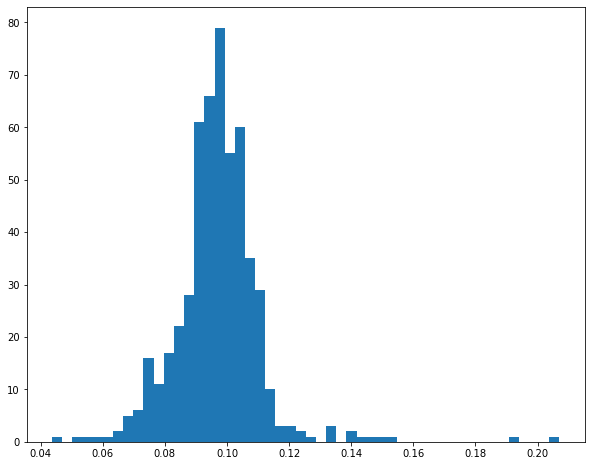

In [ ]:
reconstructions_a = model.predict(anomaly_test_data)
train_loss_a = tf.keras.losses.mae(reconstructions_a, anomaly_test_data)

plt.hist(train_loss_a, bins=50)

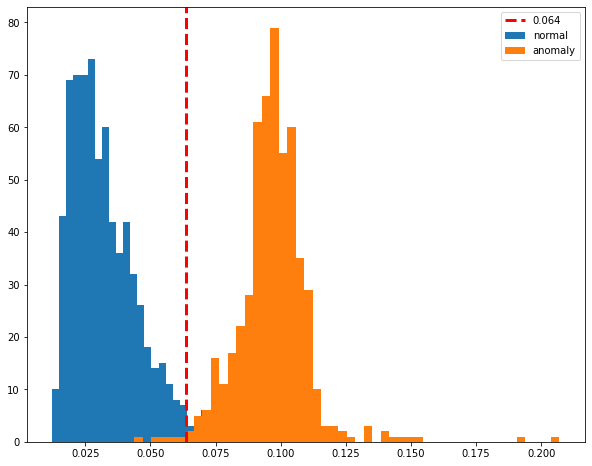

In [ ]:
plt.hist(train_loss, bins=50, label='normal')
plt.hist(train_loss_a, bins=50, label='anomaly')
plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))
plt.legend(loc='upper right')
plt.show()

In [ ]:
np.mean(train_loss_a) 

0.09703610100323665

In [ ]:
np.std(train_loss_a) 

0.01399291077112529

In [ ]:
tf.math.less(train_loss, threshold)

<tf.Tensor: shape=(723,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  Tr

Normal data %

In [ ]:
preds = tf.math.less(train_loss, threshold)

In [ ]:
n = tf.math.count_nonzero(preds)

In [ ]:
preds.shape


TensorShape([723])

In [ ]:
normal_percentage = n.numpy()/len(preds)

Anomaly

In [ ]:
preds_a = tf.math.greater(train_loss_a, threshold)

In [ ]:
a = tf.math.count_nonzero(preds_a)

In [ ]:
preds_a.shape

TensorShape([527])

In [ ]:
a= tf.math.count_nonzero(preds_a)


521

In [ ]:
anomaly_percentage = a.numpy()/len(preds_a)

In [ ]:
anomaly_percentage

0.9886148007590133

Results 

In [ ]:
print(f"Anomaly data accuracy: {anomaly_percentage}")
print(f"Normal data accuracy: {normal_percentage}")


Anomaly data accuracy: 0.9886148007590133
Normal data accuracy: 0.9681881051175657
